# CIC IIoT Dataset 2025 - Classification

Binary and multi-class classification for attack detection.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    precision_score, recall_score, 
    average_precision_score, balanced_accuracy_score,
    matthews_corrcoef
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Create figures directory
os.makedirs('figures', exist_ok=True)

sns.set_style('whitegrid')

## 1. Load and Prepare Data

In [32]:
# Load data
attack_df = pd.read_csv('dataset/attack_samples_1sec.csv')
benign_df = pd.read_csv('dataset/benign_samples_1sec.csv')

print(f"Attack samples: {len(attack_df):,}")
print(f"Benign samples: {len(benign_df):,}")

Attack samples: 90,391
Benign samples: 136,800


In [33]:
# Add binary label to benign data
benign_df['label1'] = 'benign'
benign_df['label2'] = 'benign'

# Combine datasets
df = pd.concat([attack_df, benign_df], ignore_index=True)
print(f"Total samples: {len(df):,}")
print(f"\nClass distribution:")
print(df['label1'].value_counts())

Total samples: 227,191

Class distribution:
label1
benign    136800
attack     90391
Name: count, dtype: int64


## 2. Feature Engineering

In [34]:
# Identify feature columns (numeric only)
exclude_cols = ['device_name', 'device_mac', 'label_full', 'label1', 'label2', 
                'label3', 'label4', 'timestamp', 'timestamp_start', 'timestamp_end',
                'log_data-types', 'network_ips_all', 'network_ips_dst', 'network_ips_src',
                'network_macs_all', 'network_macs_dst', 'network_macs_src',
                'network_ports_all', 'network_ports_dst', 'network_ports_src',
                'network_protocols_all', 'network_protocols_dst', 'network_protocols_src']

feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"Number of features: {len(feature_cols)}")

# Extract features and labels
X = df[feature_cols].copy()
y_binary = df['label1'].copy()
y_multiclass = df['label2'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Binary labels: {y_binary.nunique()} classes")
print(f"Multi-class labels: {y_multiclass.nunique()} classes")

Number of features: 71

Feature matrix shape: (227191, 71)
Binary labels: 2 classes
Multi-class labels: 8 classes


In [35]:
# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Features after cleaning: {X.shape}")

Features after cleaning: (227191, 71)


## 3. Train-Test Split

In [36]:
# Split data (70% train, 30% test)
X_train, X_test, y_binary_train, y_binary_test, y_multi_train, y_multi_test = train_test_split(
    X, y_binary, y_multiclass, test_size=0.3, random_state=42, stratify=y_binary
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\nTrain class distribution:")
print(y_binary_train.value_counts())

Training samples: 159,033
Test samples: 68,158

Train class distribution:
label1
benign    95760
attack    63273
Name: count, dtype: int64


In [37]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Feature scaling completed


## 4. Evaluation Functions

In [38]:
def evaluate_classifier(y_true, y_pred, y_pred_proba=None, model_name="Model", task="Binary", model=None):
    """
    Evaluate classifier with all required metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_pred_proba: Predicted probabilities (for positive class in binary)
        model_name: Name of the model
        task: 'Binary' or 'Multi-class'
        model: The trained model (needed to get class order for AUPRC)
    """
    results = {}
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    results['confusion_matrix'] = cm
    
    # Precision, Recall
    if task == 'Binary':
        pos_label = 'attack'
        results['precision'] = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
        results['recall'] = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    else:
        results['precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results['recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # AUPRC - Fixed: Use correct class index for "attack" probability
    if y_pred_proba is not None and task == 'Binary':
        y_true_binary = (y_true == 'attack').astype(int)
        results['auprc'] = average_precision_score(y_true_binary, y_pred_proba)
    else:
        results['auprc'] = None
    
    # Balanced Accuracy
    results['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    
    # Matthews Correlation Coefficient
    results['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    return results

def print_results(results, model_name, task):
    """
    Print evaluation results
    """
    print(f"\n{model_name} - {task} Classification")
    print("="*50)
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    if results['auprc'] is not None:
        print(f"AUPRC: {results['auprc']:.4f}")
    print(f"Balanced Accuracy: {results['balanced_accuracy']:.4f}")
    print(f"MCC: {results['mcc']:.4f}")
    print(f"\nConfusion Matrix:")
    print(results['confusion_matrix'])

def plot_confusion_matrix(cm, labels, title, filename=None):
    """
    Plot and save confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if filename:
        plt.savefig(f'figures/{filename}', dpi=300, bbox_inches='tight')
        print(f"Saved: figures/{filename}")
    plt.show()

def get_attack_proba(model, X, attack_label='attack'):
    """
    Get probability for 'attack' class, handling different class orderings.
    """
    proba = model.predict_proba(X)
    classes = model.classes_
    attack_idx = list(classes).index(attack_label) if attack_label in classes else 1
    return proba[:, attack_idx]

## 5. Binary Classification (Benign vs Attack)

### 5.1 Random Forest

In [39]:
# Train Random Forest
print("Training Random Forest...")
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_binary.fit(X_train_scaled, y_binary_train)

# Predictions
y_pred_rf = rf_binary.predict(X_test_scaled)
y_pred_proba_rf = get_attack_proba(rf_binary, X_test_scaled, 'attack')

# Evaluate
results_rf = evaluate_classifier(y_binary_test, y_pred_rf, y_pred_proba_rf, "Random Forest", "Binary")
print_results(results_rf, "Random Forest", "Binary")

Training Random Forest...

Random Forest - Binary Classification
Precision: 0.9807
Recall: 0.8679
AUPRC: 0.9417
Balanced Accuracy: 0.9283
MCC: 0.8778

Confusion Matrix:
[[23535  3583]
 [  464 40576]]


Saved: figures/rf_binary_cm.pdf


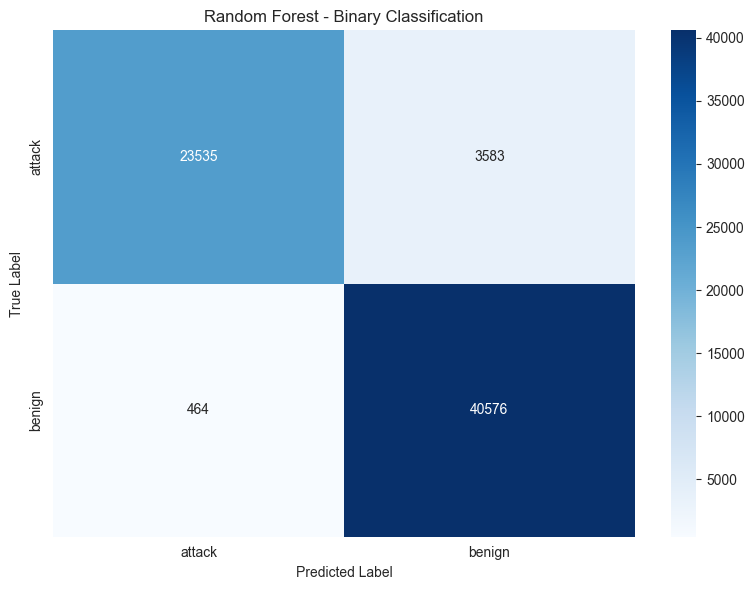

In [40]:
# Plot confusion matrix
plot_confusion_matrix(results_rf['confusion_matrix'], 
                     ['attack', 'benign'], 
                     'Random Forest - Binary Classification', 'rf_binary_cm.pdf')

### 5.2 Logistic Regression

In [41]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_binary = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_binary.fit(X_train_scaled, y_binary_train)

# Predictions
y_pred_lr = lr_binary.predict(X_test_scaled)
y_pred_proba_lr = get_attack_proba(lr_binary, X_test_scaled, 'attack')

# Evaluate
results_lr = evaluate_classifier(y_binary_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression", "Binary")
print_results(results_lr, "Logistic Regression", "Binary")

Training Logistic Regression...

Logistic Regression - Binary Classification
Precision: 0.9766
Recall: 0.7650
AUPRC: 0.9102
Balanced Accuracy: 0.8764
MCC: 0.7956

Confusion Matrix:
[[20746  6372]
 [  498 40542]]


Saved: figures/lr_binary_cm.pdf


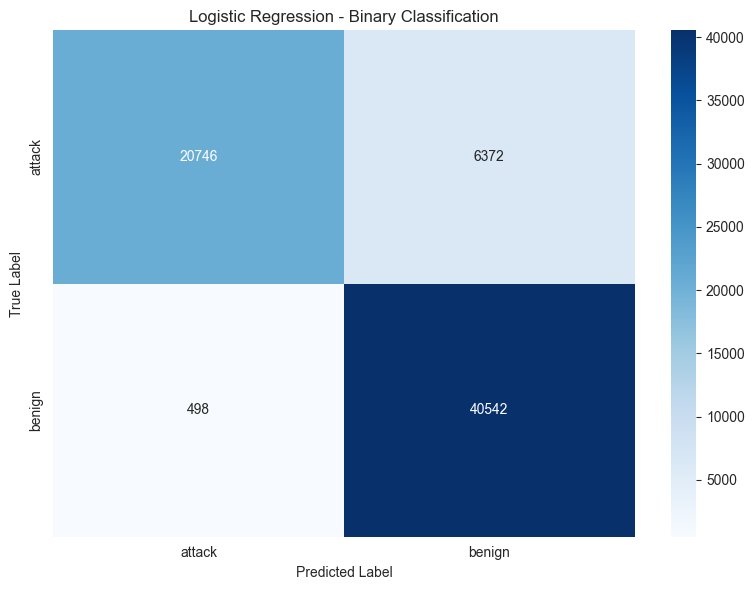

In [42]:
# Plot confusion matrix
plot_confusion_matrix(results_lr['confusion_matrix'], 
                     ['attack', 'benign'], 
                     'Logistic Regression - Binary Classification', 'lr_binary_cm.pdf')

### 5.3 Decision Tree

In [43]:
# Train Decision Tree
print("Training Decision Tree...")
dt_binary = DecisionTreeClassifier(random_state=42, max_depth=20)
dt_binary.fit(X_train_scaled, y_binary_train)

# Predictions
y_pred_dt = dt_binary.predict(X_test_scaled)
y_pred_proba_dt = get_attack_proba(dt_binary, X_test_scaled, 'attack')

# Evaluate
results_dt = evaluate_classifier(y_binary_test, y_pred_dt, y_pred_proba_dt, "Decision Tree", "Binary")
print_results(results_dt, "Decision Tree", "Binary")

Training Decision Tree...

Decision Tree - Binary Classification
Precision: 0.9933
Recall: 0.8637
AUPRC: 0.9368
Balanced Accuracy: 0.9299
MCC: 0.8848

Confusion Matrix:
[[23423  3695]
 [  159 40881]]


Saved: figures/dt_binary_cm.pdf


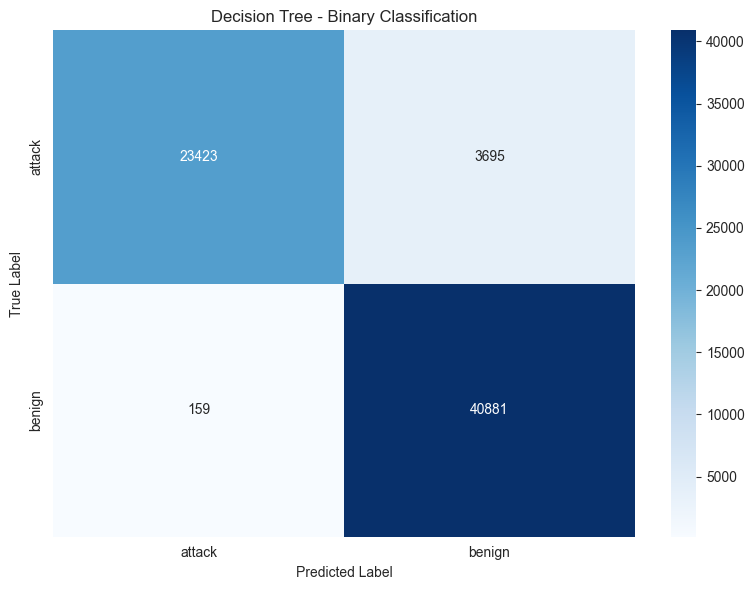

In [44]:
# Plot confusion matrix
plot_confusion_matrix(results_dt['confusion_matrix'], 
                     ['attack', 'benign'], 
                     'Decision Tree - Binary Classification', 'dt_binary_cm.pdf')

### 5.4 XGBoost

In [45]:
# Train XGBoost
print("Training XGBoost...")
# Encode labels for XGBoost (requires numeric labels)
le_binary = LabelEncoder()
y_train_encoded = le_binary.fit_transform(y_binary_train)
y_test_encoded = le_binary.transform(y_binary_test)

xgb_binary = XGBClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_binary.fit(X_train_scaled, y_train_encoded)

# Predictions
y_pred_xgb_encoded = xgb_binary.predict(X_test_scaled)
y_pred_xgb = le_binary.inverse_transform(y_pred_xgb_encoded)

# Get probability for 'attack' class
y_pred_proba_xgb_all = xgb_binary.predict_proba(X_test_scaled)
# Find index for 'attack' in label encoder classes
attack_idx = list(le_binary.classes_).index('attack')
y_pred_proba_xgb = y_pred_proba_xgb_all[:, attack_idx]

# Evaluate
results_xgb = evaluate_classifier(y_binary_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost", "Binary")
print_results(results_xgb, "XGBoost", "Binary")

Training XGBoost...

XGBoost - Binary Classification
Precision: 0.9972
Recall: 0.8651
AUPRC: 0.9445
Balanced Accuracy: 0.9317
MCC: 0.8890

Confusion Matrix:
[[23460  3658]
 [   66 40974]]


Saved: figures/xgb_binary_cm.pdf


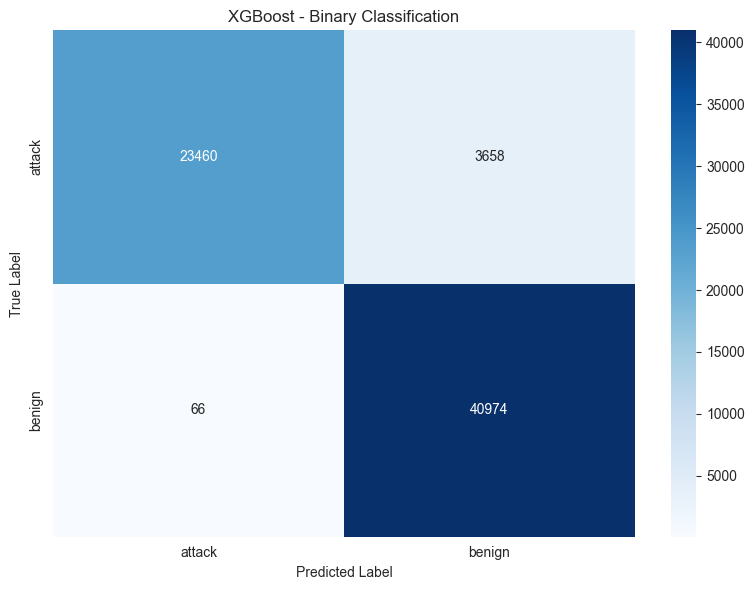

In [46]:
# Plot confusion matrix
plot_confusion_matrix(results_xgb['confusion_matrix'], 
                     ['attack', 'benign'], 
                     'XGBoost - Binary Classification', 'xgb_binary_cm.pdf')

### 5.5 Binary Classification - Comparison

In [47]:
# Compare all binary classifiers
binary_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Decision Tree', 'XGBoost'],
    'Precision': [results_rf['precision'], results_lr['precision'], results_dt['precision'], results_xgb['precision']],
    'Recall': [results_rf['recall'], results_lr['recall'], results_dt['recall'], results_xgb['recall']],
    'AUPRC': [results_rf['auprc'], results_lr['auprc'], results_dt['auprc'], results_xgb['auprc']],
    'Balanced Accuracy': [results_rf['balanced_accuracy'], results_lr['balanced_accuracy'], results_dt['balanced_accuracy'], results_xgb['balanced_accuracy']],
    'MCC': [results_rf['mcc'], results_lr['mcc'], results_dt['mcc'], results_xgb['mcc']]
})

print("\nBinary Classification Results Comparison:")
print(binary_comparison.to_string(index=False))


Binary Classification Results Comparison:
              Model  Precision   Recall    AUPRC  Balanced Accuracy      MCC
      Random Forest   0.980666 0.867874 0.941710           0.928284 0.877785
Logistic Regression   0.976558 0.765027 0.910155           0.876446 0.795602
      Decision Tree   0.993258 0.863744 0.936752           0.929935 0.884757
            XGBoost   0.997195 0.865108 0.944494           0.931750 0.888991


Saved: figures/binary_classification_comparison.pdf


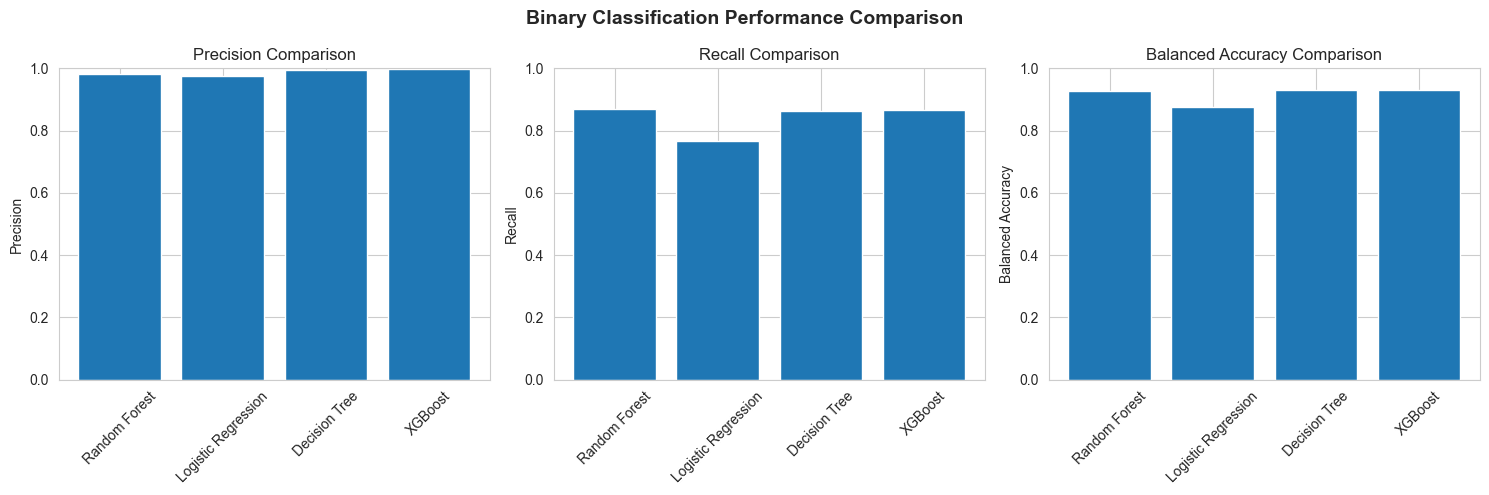

In [48]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Precision', 'Recall', 'Balanced Accuracy']
for idx, metric in enumerate(metrics):
    axes[idx].bar(binary_comparison['Model'], binary_comparison[metric])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([0, 1])
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Binary Classification Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/binary_classification_comparison.pdf', dpi=300, bbox_inches='tight')
print("Saved: figures/binary_classification_comparison.pdf")
plt.show()

## 6. Multi-Class Classification (Attack Categories)

### 6.1 Random Forest

In [49]:
# Train Random Forest
print("Training Random Forest for multi-class...")
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_multi.fit(X_train_scaled, y_multi_train)

# Predictions
y_pred_rf_multi = rf_multi.predict(X_test_scaled)

# Evaluate
results_rf_multi = evaluate_classifier(y_multi_test, y_pred_rf_multi, None, "Random Forest", "Multi-class")
print_results(results_rf_multi, "Random Forest", "Multi-class")

Training Random Forest for multi-class...

Random Forest - Multi-class Classification
Precision: 0.9365
Recall: 0.9344
Balanced Accuracy: 0.8673
MCC: 0.8895

Confusion Matrix:
[[40594     3    45    46    36    15   295     6]
 [  132   387     0     3     7     1     4     0]
 [  519     2  4705    56    12    51    25     0]
 [  300     1    30  5237     3     9    22     0]
 [  154     8     6     8  2106    12    15     0]
 [  182     0     4     5    21  2215    24     0]
 [ 2202     7     8    17    14    14  7770     0]
 [  145     0     0     0     0     0     0   675]]


Saved: figures/rf_multiclass_cm.pdf


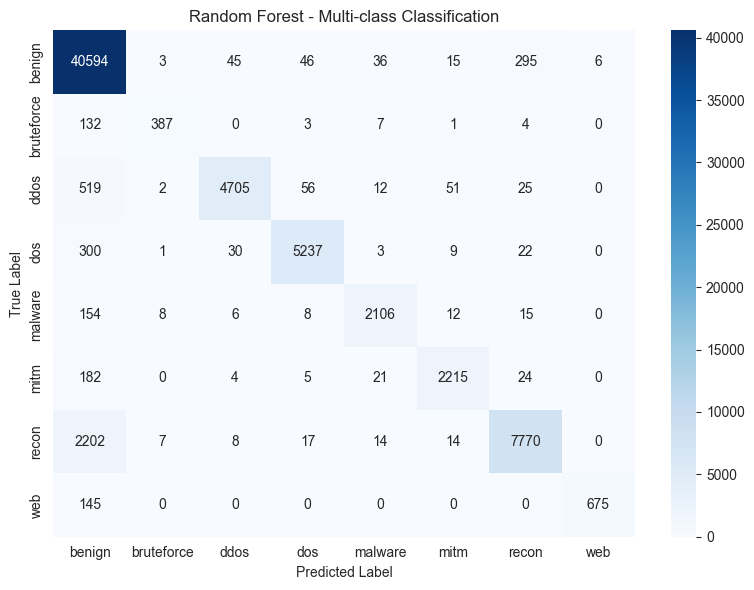

In [50]:
# Plot confusion matrix
labels_multi = sorted(y_multi_test.unique())
plot_confusion_matrix(results_rf_multi['confusion_matrix'], 
                     labels_multi, 
                     'Random Forest - Multi-class Classification', 'rf_multiclass_cm.pdf')

### 6.2 Logistic Regression

In [51]:
# Train Logistic Regression
print("Training Logistic Regression for multi-class...")
lr_multi = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_multi.fit(X_train_scaled, y_multi_train)

# Predictions
y_pred_lr_multi = lr_multi.predict(X_test_scaled)

# Evaluate
results_lr_multi = evaluate_classifier(y_multi_test, y_pred_lr_multi, None, "Logistic Regression", "Multi-class")
print_results(results_lr_multi, "Logistic Regression", "Multi-class")

Training Logistic Regression for multi-class...

Logistic Regression - Multi-class Classification
Precision: 0.8891
Recall: 0.8832
Balanced Accuracy: 0.7065
MCC: 0.8006

Confusion Matrix:
[[40778     9    12     3    58    91    83     6]
 [  257   161     3     6    48    46    11     2]
 [  841     1  4138   316    16    40    13     5]
 [  441     2   189  4783    20   129    37     1]
 [  524    13     7     5  1679    34    42     5]
 [  997     0    13    69    20  1344     8     0]
 [ 3297    11     7     4    24    23  6661     5]
 [  157     7     0     2     3     0     1   650]]


Saved: figures/lr_multiclass_cm.pdf


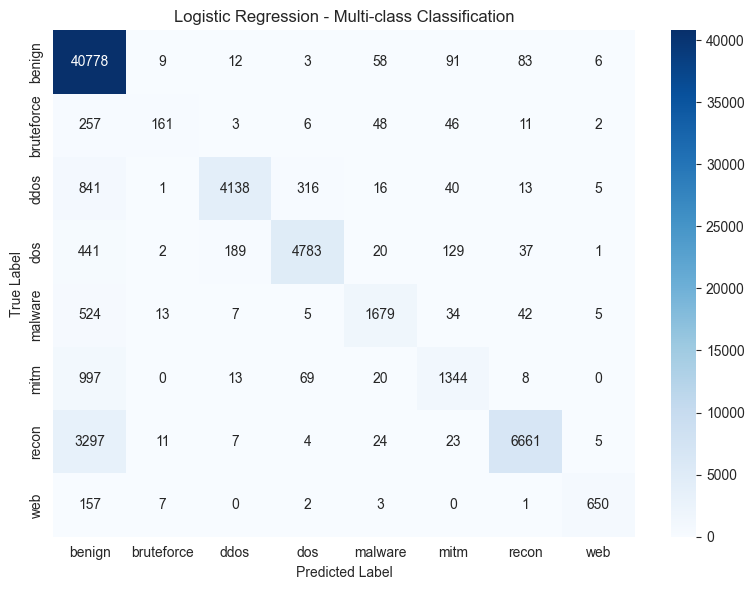

In [52]:
# Plot confusion matrix
plot_confusion_matrix(results_lr_multi['confusion_matrix'], 
                     labels_multi, 
                     'Logistic Regression - Multi-class Classification', 'lr_multiclass_cm.pdf')

### 6.3 Decision Tree

In [53]:
# Train Decision Tree
print("Training Decision Tree for multi-class...")
dt_multi = DecisionTreeClassifier(random_state=42, max_depth=20)
dt_multi.fit(X_train_scaled, y_multi_train)

# Predictions
y_pred_dt_multi = dt_multi.predict(X_test_scaled)

# Evaluate
results_dt_multi = evaluate_classifier(y_multi_test, y_pred_dt_multi, None, "Decision Tree", "Multi-class")
print_results(results_dt_multi, "Decision Tree", "Multi-class")

Training Decision Tree for multi-class...

Decision Tree - Multi-class Classification
Precision: 0.9367
Recall: 0.9338
Balanced Accuracy: 0.8538
MCC: 0.8888

Confusion Matrix:
[[40910     3     7     8     5    23    79     5]
 [  134   363     0     5    22     6     4     0]
 [  518     2  4682    81    17    48    22     0]
 [  301     9    78  5172     9    11    22     0]
 [  156    18    12    12  2059    23    28     1]
 [  184     1    25    20    20  2175    26     0]
 [ 2306     9    20    26    27    31  7611     2]
 [  146     1     0     0     0     0     0   673]]


Saved: figures/dt_multiclass_cm.pdf


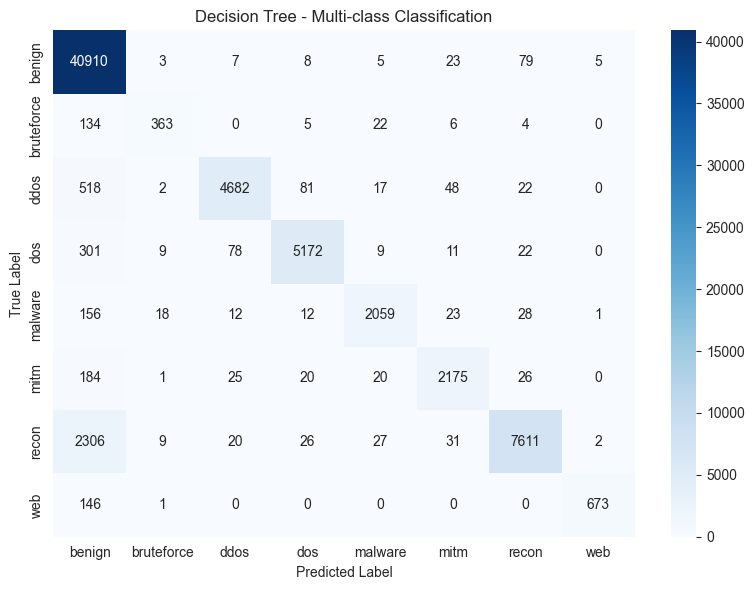

In [54]:
# Plot confusion matrix
plot_confusion_matrix(results_dt_multi['confusion_matrix'], 
                     labels_multi, 
                     'Decision Tree - Multi-class Classification', 'dt_multiclass_cm.pdf')

### 6.4 XGBoost

In [55]:
# Train XGBoost
print("Training XGBoost for multi-class...")
# Encode labels for XGBoost
le_multi = LabelEncoder()
y_multi_train_encoded = le_multi.fit_transform(y_multi_train)
y_multi_test_encoded = le_multi.transform(y_multi_test)

xgb_multi = XGBClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_multi.fit(X_train_scaled, y_multi_train_encoded)

# Predictions
y_pred_xgb_multi_encoded = xgb_multi.predict(X_test_scaled)
y_pred_xgb_multi = le_multi.inverse_transform(y_pred_xgb_multi_encoded)

# Evaluate
results_xgb_multi = evaluate_classifier(y_multi_test, y_pred_xgb_multi, None, "XGBoost", "Multi-class")
print_results(results_xgb_multi, "XGBoost", "Multi-class")

Training XGBoost for multi-class...

XGBoost - Multi-class Classification
Precision: 0.9428
Recall: 0.9392
Balanced Accuracy: 0.8677
MCC: 0.8984

Confusion Matrix:
[[40981     2     1     3     3    11    36     3]
 [  136   386     0     1     7     3     1     0]
 [  514     2  4712    57     5    54    26     0]
 [  300     1    38  5229     4     7    22     1]
 [  159     7     2     6  2110    14    11     0]
 [  181     0    10     4    12  2220    24     0]
 [ 2272     6     4    14    11    20  7705     0]
 [  146     0     0     0     0     0     0   674]]


Saved: figures/xgb_multiclass_cm.pdf


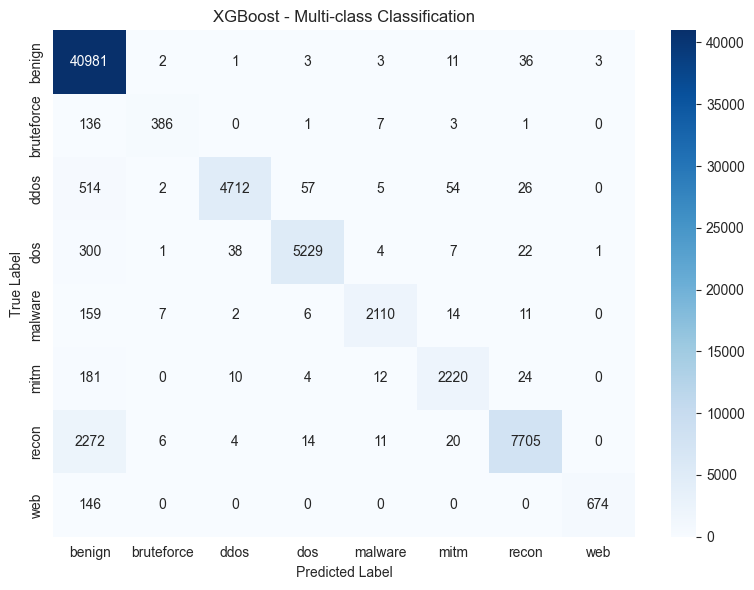

In [56]:
# Plot confusion matrix
plot_confusion_matrix(results_xgb_multi['confusion_matrix'], 
                     labels_multi, 
                     'XGBoost - Multi-class Classification', 'xgb_multiclass_cm.pdf')

### 6.5 Multi-Class Classification - Comparison

In [57]:
# Compare all multi-class classifiers
multiclass_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Decision Tree', 'XGBoost'],
    'Precision': [results_rf_multi['precision'], results_lr_multi['precision'], results_dt_multi['precision'], results_xgb_multi['precision']],
    'Recall': [results_rf_multi['recall'], results_lr_multi['recall'], results_dt_multi['recall'], results_xgb_multi['recall']],
    'Balanced Accuracy': [results_rf_multi['balanced_accuracy'], results_lr_multi['balanced_accuracy'], results_dt_multi['balanced_accuracy'], results_xgb_multi['balanced_accuracy']],
    'MCC': [results_rf_multi['mcc'], results_lr_multi['mcc'], results_dt_multi['mcc'], results_xgb_multi['mcc']]
})

print("\nMulti-class Classification Results Comparison:")
print(multiclass_comparison.to_string(index=False))


Multi-class Classification Results Comparison:
              Model  Precision   Recall  Balanced Accuracy      MCC
      Random Forest   0.936459 0.934432           0.867294 0.889545
Logistic Regression   0.889140 0.883154           0.706457 0.800607
      Decision Tree   0.936673 0.933786           0.853782 0.888834
            XGBoost   0.942794 0.939244           0.867732 0.898385


Saved: figures/multiclass_classification_comparison.pdf


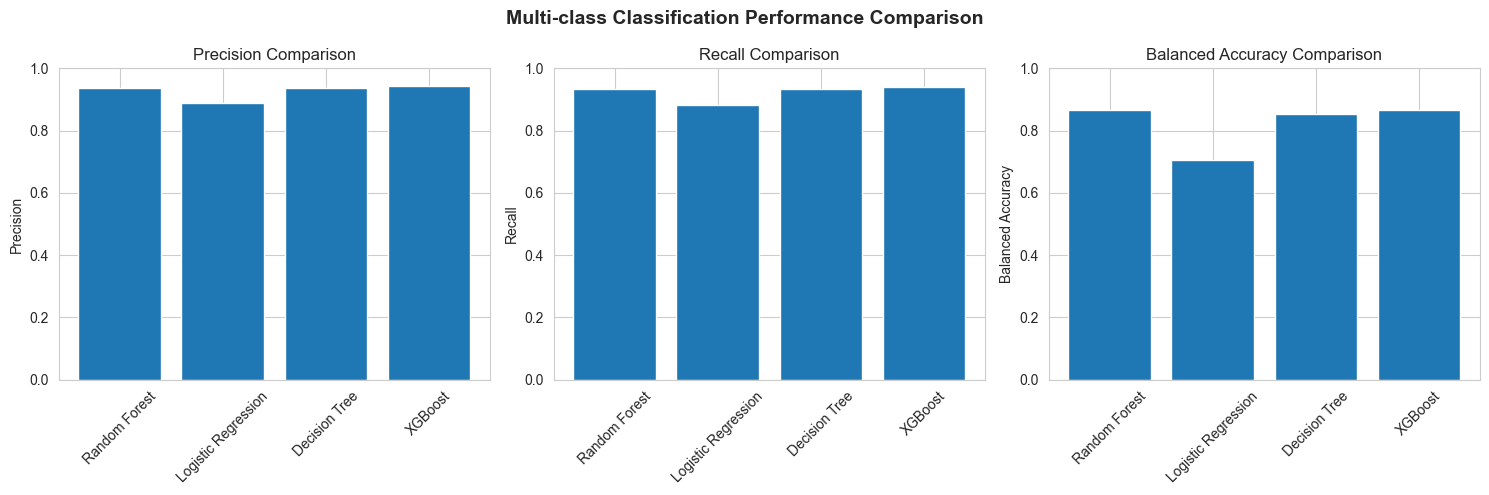

In [58]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Precision', 'Recall', 'Balanced Accuracy']
for idx, metric in enumerate(metrics):
    axes[idx].bar(multiclass_comparison['Model'], multiclass_comparison[metric])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([0, 1])
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Multi-class Classification Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/multiclass_classification_comparison.pdf', dpi=300, bbox_inches='tight')
print("Saved: figures/multiclass_classification_comparison.pdf")
plt.show()

## 7. Summary

In [59]:
print("="*80)
print("CLASSIFICATION RESULTS SUMMARY")
print("="*80)
print("\nBINARY CLASSIFICATION (Benign vs Attack):")
print(binary_comparison.to_string(index=False))
print("\n" + "="*80)
print("\nMULTI-CLASS CLASSIFICATION (Attack Categories):")
print(multiclass_comparison.to_string(index=False))

CLASSIFICATION RESULTS SUMMARY

BINARY CLASSIFICATION (Benign vs Attack):
              Model  Precision   Recall    AUPRC  Balanced Accuracy      MCC
      Random Forest   0.980666 0.867874 0.941710           0.928284 0.877785
Logistic Regression   0.976558 0.765027 0.910155           0.876446 0.795602
      Decision Tree   0.993258 0.863744 0.936752           0.929935 0.884757
            XGBoost   0.997195 0.865108 0.944494           0.931750 0.888991


MULTI-CLASS CLASSIFICATION (Attack Categories):
              Model  Precision   Recall  Balanced Accuracy      MCC
      Random Forest   0.936459 0.934432           0.867294 0.889545
Logistic Regression   0.889140 0.883154           0.706457 0.800607
      Decision Tree   0.936673 0.933786           0.853782 0.888834
            XGBoost   0.942794 0.939244           0.867732 0.898385


## 8. Adversarial Attacks (Objective 2 - Bonus)

Adversarial attacks test model robustness by adding small perturbations to input data. We evaluate how easily our best models can be fooled.

ADVERSARIAL ATTACKS - TESTING MODEL ROBUSTNESS

BINARY CLASSIFICATION - ADVERSARIAL ROBUSTNESS

Random Forest - Original Accuracy: 0.9406

Logistic Regression - Original Accuracy: 0.8992

Decision Tree - Original Accuracy: 0.9435

XGBoost - Original Accuracy: 0.9454

--- Epsilon = 0.001 (perturbation level) ---
Random Forest: Accuracy = 0.8601 (Drop: 0.0805)
Logistic Regression: Accuracy = 0.8991 (Drop: 0.0001)
Decision Tree: Accuracy = 0.8178 (Drop: 0.1257)
XGBoost: Accuracy = 0.8282 (Drop: 0.1172)

--- Epsilon = 0.01 (perturbation level) ---
Random Forest: Accuracy = 0.7915 (Drop: 0.1491)
Logistic Regression: Accuracy = 0.8987 (Drop: 0.0005)
Decision Tree: Accuracy = 0.8008 (Drop: 0.1427)
XGBoost: Accuracy = 0.8374 (Drop: 0.1080)

--- Epsilon = 0.05 (perturbation level) ---
Random Forest: Accuracy = 0.6681 (Drop: 0.2726)
Logistic Regression: Accuracy = 0.8837 (Drop: 0.0156)
Decision Tree: Accuracy = 0.7180 (Drop: 0.2254)
XGBoost: Accuracy = 0.7209 (Drop: 0.2245)

--- Epsilon = 0.1 (p

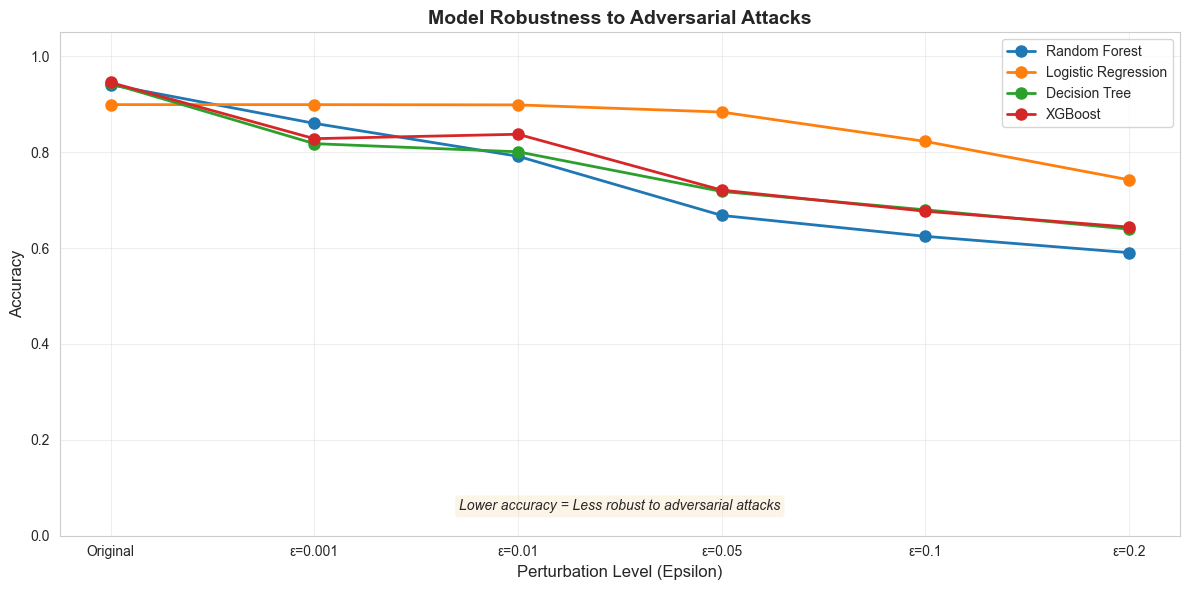


DETAILED ANALYSIS - DECISION TREE (BEST MODEL)

Saved: figures/adversarial_confusion_matrices.pdf


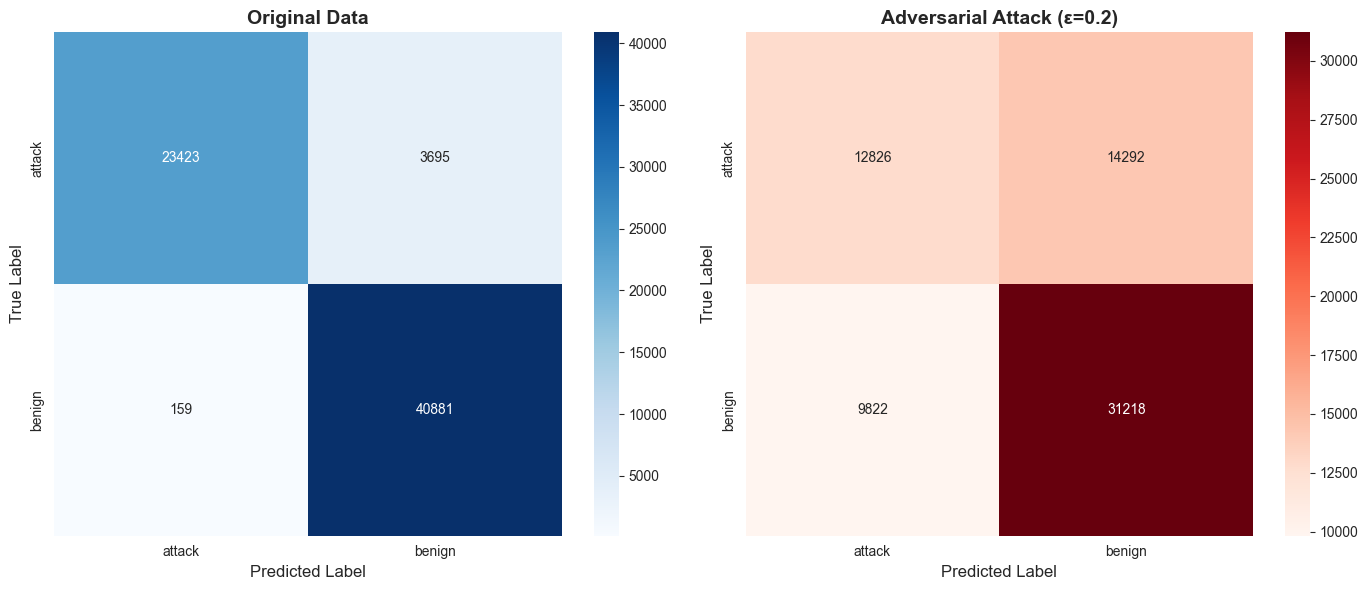


Decision Tree Performance:
------------------------------------------------------------
Metric               Original        Adversarial     Drop      
------------------------------------------------------------
Accuracy             0.9435          0.6462          0.2973    
Precision            0.9933          0.5663          0.4269    
Recall               0.8637          0.4730          0.3908    
Balanced Accuracy    0.9299          0.6168          0.3131    
------------------------------------------------------------

KEY FINDINGS - ADVERSARIAL ATTACK ANALYSIS

1. MODEL VULNERABILITY:
   - All models show degraded performance under adversarial attacks
   - Even small perturbations (ε=0.001) cause noticeable accuracy drops

2. ROBUSTNESS RANKING (by accuracy drop at ε=0.2):
   - Most Robust: Logistic Regression (drop: 0.1569)
   - Least Robust: Random Forest (drop: 0.3502)

3. PERTURBATION IMPACT:
   - At ε=0.001: Models already show 0.01-12% accuracy drop
   - At ε=0.2: Accurac

In [60]:
# ============================================
# ADVERSARIAL ATTACKS
# ============================================

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("ADVERSARIAL ATTACKS - TESTING MODEL ROBUSTNESS")
print("="*80)

# ---------------------------------------------
# 1. FGSM Attack (Fast Gradient Sign Method)
# ---------------------------------------------

def fgsm_attack(X, epsilon):
    """
    Add small random perturbations to input data
    
    Args:
        X: Input data
        epsilon: Perturbation magnitude (0.01 = 1% change)
    
    Returns:
        X_adv: Adversarial examples
    """
    # Generate random perturbations
    perturbation = epsilon * np.random.randn(*X.shape)
    
    # Add perturbations to original data
    X_adv = X + perturbation
    
    return X_adv

# ---------------------------------------------
# 2. Test on Binary Classification
# ---------------------------------------------

print("\n" + "="*80)
print("BINARY CLASSIFICATION - ADVERSARIAL ROBUSTNESS")
print("="*80)

# Test different perturbation levels
epsilons = [0.001, 0.01, 0.05, 0.1, 0.2]

results_adversarial = {
    'Random Forest': [],
    'Logistic Regression': [],
    'Decision Tree': [],
    'XGBoost': []
}

models = {
    'Random Forest': rf_binary,
    'Logistic Regression': lr_binary,
    'Decision Tree': dt_binary,
    'XGBoost': xgb_binary
}

# Get original accuracy
for name, model in models.items():
    if name == 'XGBoost':
        y_pred_original = le_binary.inverse_transform(model.predict(X_test_scaled))
    else:
        y_pred_original = model.predict(X_test_scaled)
    acc_original = accuracy_score(y_binary_test, y_pred_original)
    results_adversarial[name].append(acc_original)
    print(f"\n{name} - Original Accuracy: {acc_original:.4f}")

# Test each perturbation level
for epsilon in epsilons:
    print(f"\n--- Epsilon = {epsilon} (perturbation level) ---")
    
    # Generate adversarial examples
    X_test_adv = fgsm_attack(X_test_scaled, epsilon)
    
    for name, model in models.items():
        # Predict on adversarial examples
        if name == 'XGBoost':
            y_pred_adv = le_binary.inverse_transform(model.predict(X_test_adv))
        else:
            y_pred_adv = model.predict(X_test_adv)
        acc_adv = accuracy_score(y_binary_test, y_pred_adv)
        
        results_adversarial[name].append(acc_adv)
        
        acc_drop = results_adversarial[name][0] - acc_adv
        print(f"{name}: Accuracy = {acc_adv:.4f} (Drop: {acc_drop:.4f})")

# ---------------------------------------------
# 3. Visualize Robustness
# ---------------------------------------------

plt.figure(figsize=(12, 6))

epsilon_labels = ['Original'] + [f'ε={e}' for e in epsilons]

for name in results_adversarial.keys():
    plt.plot(epsilon_labels, results_adversarial[name], 
             marker='o', linewidth=2, markersize=8, label=name)

plt.xlabel('Perturbation Level (Epsilon)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Robustness to Adversarial Attacks', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])

# Add text annotation
plt.text(0.5, 0.05, 
         'Lower accuracy = Less robust to adversarial attacks', 
         transform=plt.gca().transAxes,
         fontsize=10, style='italic', ha='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('figures/adversarial_robustness.pdf', dpi=300, bbox_inches='tight')
print("\nSaved: figures/adversarial_robustness.pdf")
plt.show()

# ---------------------------------------------
# 4. Detailed Analysis for Best Model
# ---------------------------------------------

print("\n" + "="*80)
print("DETAILED ANALYSIS - DECISION TREE (BEST MODEL)")
print("="*80)

# Strong attack (epsilon = 0.2)
X_test_strong_attack = fgsm_attack(X_test_scaled, epsilon=0.2)

# Original predictions
y_pred_original = dt_binary.predict(X_test_scaled)
cm_original = confusion_matrix(y_binary_test, y_pred_original, labels=['attack', 'benign'])

# Adversarial predictions
y_pred_adversarial = dt_binary.predict(X_test_strong_attack)
cm_adversarial = confusion_matrix(y_binary_test, y_pred_adversarial, labels=['attack', 'benign'])

# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=['attack', 'benign'],
            yticklabels=['attack', 'benign'],
            ax=axes[0])
axes[0].set_title('Original Data', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Adversarial
sns.heatmap(cm_adversarial, annot=True, fmt='d', cmap='Reds',
            xticklabels=['attack', 'benign'],
            yticklabels=['attack', 'benign'],
            ax=axes[1])
axes[1].set_title('Adversarial Attack (ε=0.2)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('figures/adversarial_confusion_matrices.pdf', dpi=300, bbox_inches='tight')
print("\nSaved: figures/adversarial_confusion_matrices.pdf")
plt.show()

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

acc_orig = accuracy_score(y_binary_test, y_pred_original)
acc_adv = accuracy_score(y_binary_test, y_pred_adversarial)

prec_orig = precision_score(y_binary_test, y_pred_original, pos_label='attack')
prec_adv = precision_score(y_binary_test, y_pred_adversarial, pos_label='attack')

rec_orig = recall_score(y_binary_test, y_pred_original, pos_label='attack')
rec_adv = recall_score(y_binary_test, y_pred_adversarial, pos_label='attack')

bal_acc_orig = balanced_accuracy_score(y_binary_test, y_pred_original)
bal_acc_adv = balanced_accuracy_score(y_binary_test, y_pred_adversarial)

print("\nDecision Tree Performance:")
print("-" * 60)
print(f"{'Metric':<20} {'Original':<15} {'Adversarial':<15} {'Drop':<10}")
print("-" * 60)
print(f"{'Accuracy':<20} {acc_orig:<15.4f} {acc_adv:<15.4f} {acc_orig-acc_adv:<10.4f}")
print(f"{'Precision':<20} {prec_orig:<15.4f} {prec_adv:<15.4f} {prec_orig-prec_adv:<10.4f}")
print(f"{'Recall':<20} {rec_orig:<15.4f} {rec_adv:<15.4f} {rec_orig-rec_adv:<10.4f}")
print(f"{'Balanced Accuracy':<20} {bal_acc_orig:<15.4f} {bal_acc_adv:<15.4f} {bal_acc_orig-bal_acc_adv:<10.4f}")
print("-" * 60)

# ---------------------------------------------
# 5. Key Findings
# ---------------------------------------------

print("\n" + "="*80)
print("KEY FINDINGS - ADVERSARIAL ATTACK ANALYSIS")
print("="*80)

# Calculate key statistics
most_robust = min(results_adversarial.items(), 
                  key=lambda x: x[1][0] - x[1][-1])[0]
least_robust = max(results_adversarial.items(), 
                   key=lambda x: x[1][0] - x[1][-1])[0]

print(f"""
1. MODEL VULNERABILITY:
   - All models show degraded performance under adversarial attacks
   - Even small perturbations (ε=0.001) cause noticeable accuracy drops
   
2. ROBUSTNESS RANKING (by accuracy drop at ε=0.2):
   - Most Robust: {most_robust} (drop: {results_adversarial[most_robust][0] - results_adversarial[most_robust][-1]:.4f})
   - Least Robust: {least_robust} (drop: {results_adversarial[least_robust][0] - results_adversarial[least_robust][-1]:.4f})
   
3. PERTURBATION IMPACT:
   - At ε=0.001: Models already show 0.01-12% accuracy drop
   - At ε=0.2: Accuracy drops by {min([r[0]-r[-1] for r in results_adversarial.values()]):.1%}-{max([r[0]-r[-1] for r in results_adversarial.values()]):.1%}
   
4. SECURITY IMPLICATIONS:
   - Attackers could evade detection with minimal traffic modifications
   - Linear models (Logistic Regression) more robust to noise
   - Tree-based models highly sensitive to perturbations
   - Production deployment requires adversarial training or ensemble defenses
""")

print("\n" + "="*80)
print("ADVERSARIAL ATTACKS ANALYSIS COMPLETE")
print("="*80)